# Test hipy.efit


## Test CompositePDF class

J. A. Hernando-Morata

05/04/2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [4]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats    as stats

import warnings
warnings.filterwarnings('ignore')

In [5]:
import hipy.pltext as pltext
import hipy.utils  as ut
import hipy.efit   as efit

pltext.style()

## CompositePDF


In [15]:
def test_compositepdf(com, par, xrange, nbins = 100):
    
    par = np.array(par)
    
    print('--- test masks ---')
    print('mask 0 :', *np.where(com.mask0 == True))
    nstats = len(com.stats)
    for i in range(nstats):
        print('mask', i+1, ': ', *np.where(com.masks[i] == True))
    
    subplot = pltext.canvas(2)
    
    subplot(1)
    xs = np.linspace(*xrange, nbins)
    plt.plot(xs, com.pdf(xs, *par), label = 'composite'); plt.grid();
    for i in range(nstats):
        imask = com.masks[i]
        plt.plot(xs, com.stats[i].pdf(xs, *par[imask]), label = 'pdf_'+str(i))
    plt.title('composite pdf'); plt.legend()
    dx = xs[1] - xs[0]
    print('--- test com pdf intgral ---')
    print('integral com pdf : {:6.5f}'.format(dx * np.sum(com.pdf(xs, *par))))

    subplot(2)
    rv = com.rvs(*par)
    pltext.hist(rv, nbins);
    plt.title('rv')
    
    ll   = com.loglike
    mask = com.mask0 
    res = efit.mll(rv, ll, par, mask = mask, sigma = True)    
    print('--- test mll fit ---')
    print('mask ', *np.where(mask == True), 'mll ', 
          res.success, 'values ', res.x[mask], 'sigma ', res.sigma[mask])
    for i in range(nstats):
        mask = com.masks[i] 
        if (np.sum(mask) <= 0): continue
        res = efit.mll(rv, ll, par, mask = mask, sigma = True)
        print('mask ', i + 1, *np.where(mask == True), 'mll ', 
              res.success, 'values ', res.x[mask], 'sigma ', res.sigma[mask])
    return
        

### Test Composite PDFs with names

--- test masks ---
mask 0 : [0 3 6]
mask 1 :  [1 2]
mask 2 :  [4 5]
mask 3 :  [7 8]
--- test com pdf intgral ---
integral com pdf : 1.00000
--- test mll fit ---
mask  [0 3 6] mll  True values  [40.42929046 99.05087411 82.51978153] sigma  [ 6.7303826  10.35051215  9.46594254]
mask  1 [1 2] mll  True values  [-5.19298499  1.06241411] sigma  [0.18728394 0.16622597]
mask  2 [4 5] mll  True values  [-0.23315162  1.03442819] sigma  [0.10793609 0.08881367]
mask  3 [7 8] mll  True values  [4.97878817 0.92562493] sigma  [0.10681527 0.08464571]


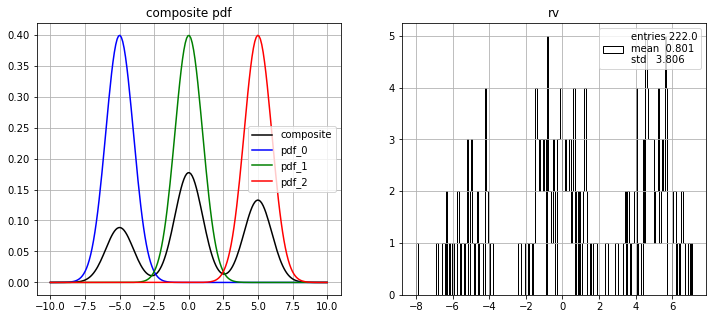

In [24]:
names  = ('gaus', 'gaus', 'gaus') 
com0   = efit.CompositePDF(names)
par    = (50, -5., 1., 100, 0., 1., 75, 5., 1.)
xrange = (-10. ,10)
nbins  = 200
test_compositepdf(com0, par, xrange, nbins)

### Test Composite PDFs with parameters

complete parameter  [100.  -3.   1.  50.   1.   1.  50.   5.   1.]
--- test masks ---
mask 0 : [0 3 6]
mask 1 :  [1 2]
mask 2 :  [4 5]
mask 3 :  [7 8]
--- test com pdf intgral ---
integral com pdf : 1.00000
--- test mll fit ---
mask  [0 3 6] mll  True values  [97.23514402 51.77200739 53.99291281] sigma  [10.34915643  7.92863355  7.85168062]
mask  1 [1 2] mll  True values  [-2.84654257  1.01533624] sigma  [0.11595087 0.09469397]
mask  2 [4 5] mll  True values  [0.90223644 1.13433456] sigma  [0.20603159 0.22501674]
mask  3 [7 8] mll  True values  [4.74180661 0.80643856] sigma  [0.12750033 0.10391199]


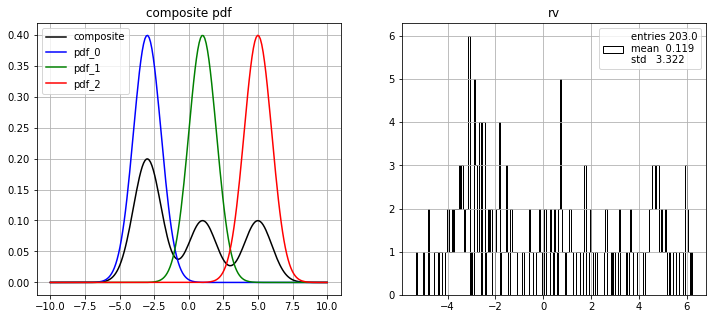

In [18]:
pdfs = [efit.stat(name) for name in ['gaus', 'gaus', 'gaus']]
ns   = (100, 50, 50)
pars = ((-3., 1.), (1., 1.), (5., 1.))
par  = np.concatenate([(ni, *par) for ni, par in zip(ns, pars)])
ns   = [len(par) for par in pars]

print('complete parameter ', par)
com1  = efit.CompositePDF(pdfs, ns)
test_compositepdf(com1, par, xrange, nbins)

### Test Composite PDFs with no parameters

--- test masks ---
mask 0 : [0 1 2]
mask 1 :  []
mask 2 :  []
mask 3 :  []
--- test com pdf intgral ---
integral com pdf : 1.00000
--- test mll fit ---
mask  [0 1 2] mll  True values  [113  17  98] sigma  [11.3  1.7  9.8]


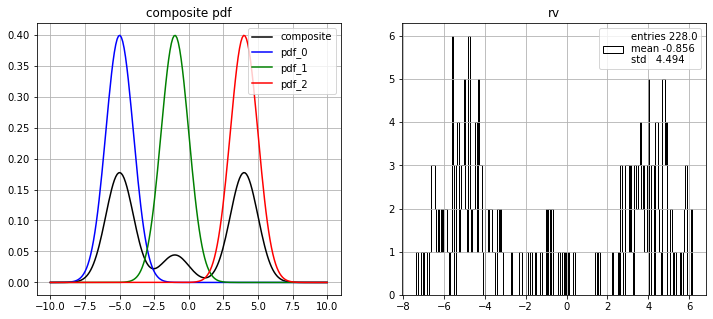

In [19]:
mus  = (-5, -1, 4)
pdfs = [stats.norm(loc = mu) for mu in mus]
ns   = (0, 0, 0)
par  = (100, 25, 100)

com2 = efit.CompositePDF(pdfs, ns)
test_compositepdf(com2, par, xrange, nbins)

### Test Composite with histogram-PDFs

--- test masks ---
mask 0 : [0 1 2]
mask 1 :  []
mask 2 :  []
mask 3 :  []
--- test com pdf intgral ---
integral com pdf : 1.00503
--- test mll fit ---
mask  [0 1 2] mll  True values  [105  27  85] sigma  [10.5  2.7  8.5]


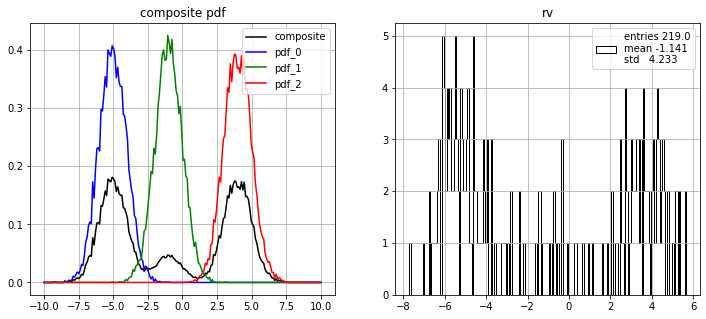

In [27]:
mus   = (-5, -1, 4)
ns    = (0, 0, 0)
par   = (100, 25, 100)
size  = 10000
xrange = (-10., 10.)
nbins  = 200

def _ipdf(mu):
    rv  = stats.norm.rvs(loc = mu, size = size)
    his = np.histogram(rv, nbins, range = xrange)
    return stats.rv_histogram(his)

pdfs = [_ipdf(mu) for mu in mus]

com3 = efit.CompositePDF(pdfs, ns)
test_compositepdf(com3, par, xrange, nbins)

In [37]:
try: 
    efit.CompositePDF(pdfs)
except:
    print('Ok, Error catch')
    
try: 
    efit.CompositePDF(pdfs, (1, 2))
except:
    print('Error catch')

Ok, Error catch
Error catch
